# 1) Introduction: The Crime Analysis task ..._Markdown_, **10 Marks**, Max 300 Words


## Solution

### 1- BACKGROUND
Crimes involving the use of guns account for around 0.4 per cent of all recorded crimes in England and Wales and have doubled since the mid to late 1990s [1] with the global trade in illicit drugs taken an annual turnover worth billions of pounds. 
This increase has come against a backdrop of increasingly restrictive laws and increasingly sophisticated public policy measures. Cannabis, which is the most widely consumed illicit drug in England, and shocking guns killings have raised considerable public concern. Police, politicians and media reports have described the emergence of these vice, particularly in some inner-city areas of England as ‘chaotic’ and has far-reaching political, cultural and economic repercussions, adversely affecting prison populations, levels of gun crime, social exclusion and public health and community safety. The UK has a higher proportion of drug and gun crime among the adult population than any of its European neighbours[2]. These consequences and impacts are felt disproportionately by the urban poor and minority ethnic groups. Relatively little, however, is known about criminal attitudes towards and trafficking in illegal drugs and guns, restraining policy developments, policing practices, and understanding the impact of legislation.

### 2- AIMS AND OBJECTIVES
The aim of this project is to examine the increasing, decreasing or stable nature of the violent/violence and sexual crime type data recorded over a period. Also to determine whether there are more firearms per head in Birmingham than any other states in the UK and the association between firearms and drug offenses.

### 3- TECHNICAL APPROACH
Development of a big data analysis algorithms to multi-terabyte dataset for visualization and cloud computing techniques. Analyze datasets (all crime data, LSOA data, UK HPI data and postcodes data) and machine learning algorithms (Linear regression) to identify those that address specific big data problem needs such as the claims mentioned in the brief. Critical evaluation to determine if violent/violence or sexual crime is increasing, decreasing or stable and whether there are more firearms per head incidents in Birmingham than any other states in the UK while considering the association with drug offenses. This involves considering the months, geography, geography code, residents and LSOA code and available processing time. Design and develop using Pyspark that integrate with Azure computing services. Critically evaluate and interpret primary research to identify its applicability to the claims mentioned. For claim 1, it involves applying time series approach to standardization, filtering the crime types to violent crime or violence and sexual offenses while counting the number of occurrences using the month variable. This is then visualized using the line plot, trend plot, scatter plot and bar chart. For claim 2, it involves the use of statistical analysis to filter through the crime types where possession of weapons and offender sent to prison exist, this is categorised as firearms and counted per geography/states. The sum of the firearms per geography is divided by the sum of the residents per geography/states. From this analysis, the number of firearms incidents per head can be group alongside the geography/states where it is decided whether Birmingham has more firearms incident per head incidents. For claim 3, using model fitting to determine the association between firearms crime type and drug offense crime type, where the count for each crime type is computed and parse into a data frame, after which it is separated into training, testing sets and fitted into a linear regression model for analysis. The association can be determined using correlation and then visualized.


# 2) Component Selection and Data Pipeline Implementation _code_	**10 Marks**

In [1]:
# import the various libriaries

import pandas as pd

import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt

import pyspark.sql.functions as F
from pyspark.sql.functions import *
from pyspark import SparkFiles
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import count, avg, sum, col, to_date

from pandas.plotting import scatter_matrix

#from pyspark.mllib.stat import Statistics
from pyspark.ml.linalg import Vectors
from pyspark.sql import Row
from pyspark.ml.stat import Correlation
from pyspark.ml.stat import Summarizer
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SQLContext

import seaborn as sns; sns.set_theme()

import statsmodels.api as sm
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

In [2]:
#Execute the SparkSession

spark = SparkSession\
.builder\
.appName("Crime Type Analysis App")\
.getOrCreate()

#show the spark version and app name
sc = spark.sparkContext
sql_c = SQLContext(sc)
sc

<SparkContext master=local[*] appName=Crime Type Analysis App>

In [4]:
#The Crime dataset is read from a blob storage, rename the columns for easy labelling and parse to a dataframe df1_raw

url = "https://kporo1.blob.core.windows.net/kabby1/all_crimes21_hdr.txt.gz"
spark.sparkContext.addFile(url)

df1_raw = spark.read.csv("file://" + SparkFiles.get("all_crimes21_hdr.txt.gz"), header=True, inferSchema= True)\
.withColumnRenamed('Reported by', 'Reportedby')\
.withColumnRenamed('Falls within', 'Fallswithin')\
.withColumnRenamed('LSOA code', 'LSOAcode')\
.withColumnRenamed('LSOA name', 'LSOAname')\
.withColumnRenamed('Crime type', 'Crimetype')\
.withColumnRenamed('Last outcome category', 'Lastoutcome')


In [5]:
#It was discovered that the dataset contains null values, This is handled by replacing null values with zero

df = df1_raw.na.fill(value=0)

In [3]:
#The LSOA dataset is read from a blob storage, rename the columns for easy labelling and parse to a dataframe df2_raw

url1 = "https://kporo1.blob.core.windows.net/kabby1/LSOA_pop_v2.csv"
spark.sparkContext.addFile(url1)

df2_raw = spark.read.csv("file://" + SparkFiles.get("LSOA_pop_v2.csv"), header=True, inferSchema= True)\
.withColumnRenamed('geography code', 'geographycode')\
.withColumnRenamed('Variable: All usual residents; measures: Value', 'residents')\
.withColumnRenamed('Variable: Density (number of persons per hectare); measures: Value','density')


In [6]:
#It was discovered that the dataset contains null values, This is handled by replacing null values with zero

df2= df2_raw.na.fill(value=0)

In [7]:
#The postcodes dataset is read from a blob storage and parse to a dataframe df3_raw

url2 = "https://kporo1.blob.core.windows.net/kabby1/postcodes.gz"
spark.sparkContext.addFile(url2)

df3_raw = spark.read.csv("file://" + SparkFiles.get("postcodes.gz"), header=True, inferSchema= True)


In [9]:
#It was discovered that the dataset contains null values, This is handled by replacing null values with zero

df3= df3_raw.na.fill(value=0)

In [10]:
#The UK HPI dataset is read from a blob storage and parse to a dataframe df4_raw

url3 = "https://kporo1.blob.core.windows.net/kabby1/UK-HPI-full-file-2017-08.csv.gz"
spark.sparkContext.addFile(url3)

df4_raw = spark.read.csv("file://" + SparkFiles.get("UK-HPI-full-file-2017-08.csv.gz"), header=True, inferSchema= True)



In [11]:
#It was discovered that the dataset contains null values, This is handled by replacing null values with zero

df4 = df4_raw.na.fill(value=0)

# 3) Data Extraction and Filtering ... _code_, 10 Marks


### 1.	Filter the dataset so that crimes refer to appropriate crimes only


## Solution
It is essential that the Crimetype column is filtered to shows the various crime types, after which Violent crime and Violence and sexual offences is focused to decide if it is increasing or decreasing

In [12]:
# Filtering out the crime types for violent crime
df.filter(df.Crimetype == "Violent crime").show

<bound method DataFrame.show of DataFrame[Crime ID: string, Month: string, Reportedby: string, Fallswithin: string, Longitude: double, Latitude: double, Location: string, LSOAcode: string, LSOAname: string, Crimetype: string, Lastoutcome: string, Context: string]>

In [7]:
# Filtering out the crime types for robbery
df.filter(df.Crimetype == "Robbery").show

<bound method DataFrame.show of DataFrame[Crime ID: string, Month: string, Reportedby: string, Fallswithin: string, Longitude: int, Latitude: int, Location: string, LSOA code: string, LSOAname: string, Crimetype: string, Lastoutcome: string, Context: string]>

In [8]:
# Filtering out the crime types for possession of weapon
df.filter(df.Crimetype == "Possession of weapon").show

<bound method DataFrame.show of DataFrame[Crime ID: string, Month: string, Reportedby: string, Fallswithin: string, Longitude: int, Latitude: int, Location: string, LSOA code: string, LSOAname: string, Crimetype: string, Lastoutcome: string, Context: string]>

In [9]:
# Filtering out the crime types for drugs
df.filter(df.Crimetype == "drugs").show

<bound method DataFrame.show of DataFrame[Crime ID: string, Month: string, Reportedby: string, Fallswithin: string, Longitude: int, Latitude: int, Location: string, LSOA code: string, LSOAname: string, Crimetype: string, Lastoutcome: string, Context: string]>

In [10]:
# Filtering out the crime types for burglary
df.filter(df.Crimetype == "Burglary").show

<bound method DataFrame.show of DataFrame[Crime ID: string, Month: string, Reportedby: string, Fallswithin: string, Longitude: int, Latitude: int, Location: string, LSOA code: string, LSOAname: string, Crimetype: string, Lastoutcome: string, Context: string]>

In [11]:
df.schema

StructType(List(StructField(Crime ID,StringType,true),StructField(Month,StringType,true),StructField(Reportedby,StringType,true),StructField(Fallswithin,StringType,true),StructField(Longitude,IntegerType,true),StructField(Latitude,IntegerType,true),StructField(Location,StringType,true),StructField(LSOA code,StringType,true),StructField(LSOAname,StringType,true),StructField(Crimetype,StringType,true),StructField(Lastoutcome,StringType,true),StructField(Context,StringType,true)))

In [12]:
df.head()

Row(Crime ID=None, Month='2010-12', Reportedby='Avon and Somerset Constabulary', Fallswithin='Avon and Somerset Constabulary', Longitude=None, Latitude=None, Location='On or near Daffords Buildings', LSOA code='E01014409', LSOAname='Bath and North East Somerset 004A', Crimetype='Anti-social behaviour', Lastoutcome=None, Context=None)

In [13]:
#display the desired columns of Month and the count of the crimetypes(violent crime or Violence and sexual offences)using the crimetype as a condition, parsing to a new dataframe dfg

dfg = (df
.select("*")
 .where((df.Crimetype == 'Violent crime' )|(df.Crimetype == 'Violence and sexual offences') )
 .groupBy("Month")
.agg(count("Month").alias("Violence_Crime_Count"))
.orderBy("Month", ascending=True))


In [14]:
dfg.head(6)

[Row(Month='2010-12', Violence_Crime_Count=57580),
 Row(Month='2011-01', Violence_Crime_Count=59823),
 Row(Month='2011-02', Violence_Crime_Count=56691),
 Row(Month='2011-03', Violence_Crime_Count=62326),
 Row(Month='2011-04', Violence_Crime_Count=64299),
 Row(Month='2011-05', Violence_Crime_Count=63633)]

In [15]:
# converting the result to pandas for plotting

pdf = dfg.toPandas()
pdf

,Month,Violence_Crime_Count
0,2010-12,57580
1,2011-01,59823
2,2011-02,56691
3,2011-03,62326
4,2011-04,64299
...,...,...
121,2021-01,141414
122,2021-02,135101
123,2021-03,166668
124,2021-04,153789


2.  To see whether crime cartegories are increasing, The values are extracted as a time series.


In [16]:
#Convert to a datetime series
pdf.date = pdf.Month.astype('datetime64[ns]')
pdf2 = pdf.set_index(pd.to_datetime(pdf.date))

<ipython-input-16-d671dbe76c89>:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  pdf.date = pdf.Month.astype('datetime64[ns]')


In [17]:
pdf2.index

DatetimeIndex(['2010-12-01', '2011-01-01', '2011-02-01', '2011-03-01',
               '2011-04-01', '2011-05-01', '2011-06-01', '2011-07-01',
               '2011-08-01', '2011-09-01',
               ...
               '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01',
               '2020-12-01', '2021-01-01', '2021-02-01', '2021-03-01',
               '2021-04-01', '2021-05-01'],
              dtype='datetime64[ns]', name='Month', length=126, freq=None)

# 4) Design, Development and reasoning behind use of multiple visualization methods, statistics, and machine learning Models,  _markdown_, _code_,  _markdown_, 20 Marks

## Solution

In order to produce forecasts and guide strategic decision-making, time series forecasting involves examining time series data using statistics and modelling[3]. Important features involves Routine calculation that can be automated and can be applied to many different scenarios without relying on qualitative knowledge about the underlying phenomena.

### Plot 1) Line graph

In [18]:
#The line graph is plotted using the violent crime count as the y-axis and the month(month and year) as the x-axis inorder to investigate the crime type

plt.figsize=(20, 6)

pdf2.plot(y='Violence_Crime_Count', x='Month',marker='.', linestyle='-', linewidth=0.5,\
         subplots=False,
              label='Violent Crime Report',
              title='Violent crime Vs Month')
plt.ylabel('Violent Crime')

Text(0, 0.5, 'Violent Crime')

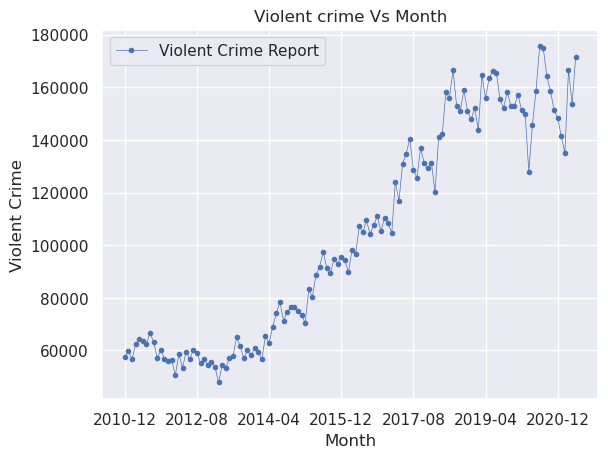

In [19]:
plt.show()

In [ ]:
Interpretation: The following plot shows a clear upward trend. There may also be a slight curve in the data, 
because the increase in the number of violent crime values seems to increase over the months. When depicting 
data or information that changes consistently over time, a line graph is helpful.

### Plot 2) Trend plot

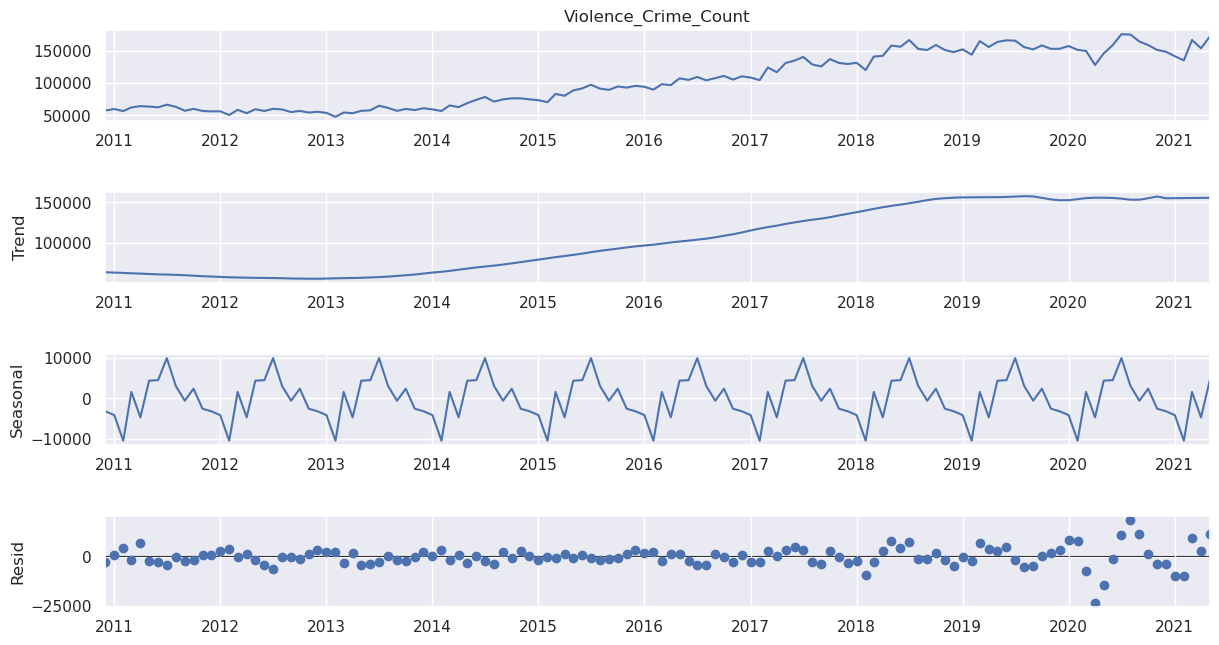

In [20]:
#To plot the trend plot using seasonal decompose feature
decomposition = sm.tsa.seasonal_decompose(pdf2['Violence_Crime_Count'], model='additive',extrapolate_trend='freq')
fig = decomposition.plot()
fig.set_size_inches(14,7)
plt.show()

The above shows that the gradual increase in the number of violence reported over an 11 year period. It is noticed that the number peaked at the year 2021. 

The trend component refers to the increase in violence over the years.

The seasonal period is approximately 11 year period and it peaks at a count of 1000 and bottoms out for all the years at -1000 before peaking at 1000 again. 

The residual plot is what remains whenseasonality and trend have been extracted from the time series.

### Plot 3) Scatter plot

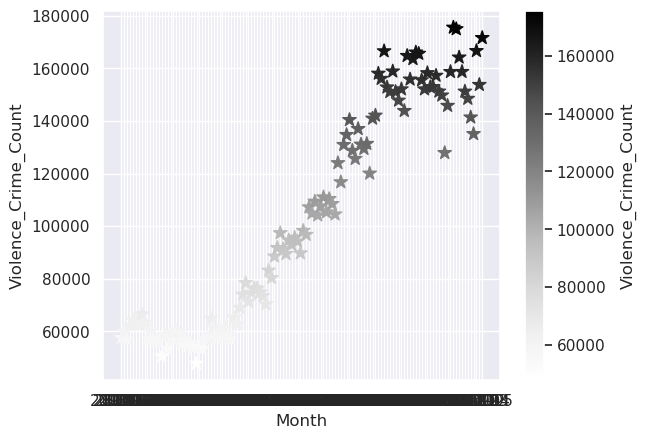

In [21]:
#Plot the scatter plot using the number of violence or violence crime count against the months

pdf.plot.scatter(x='Month', y='Violence_Crime_Count', c='Violence_Crime_Count', marker="*", s=100)
plt.show()


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


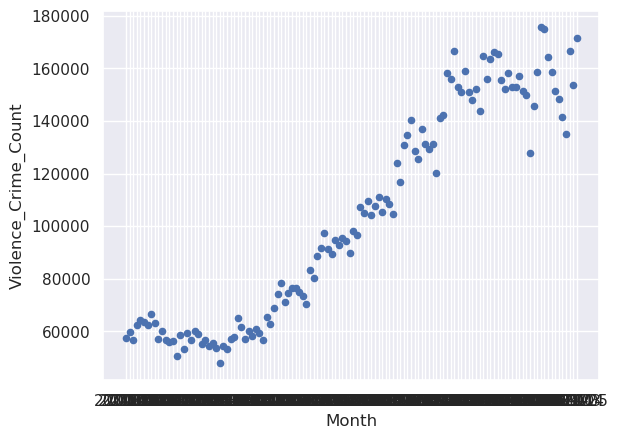

In [22]:
pdf.plot.scatter(x='Month', y='Violence_Crime_Count')
plt.show()

The scatterplots displays a moderately strong, positive relationship. As the number of violence increases, the month also tends to increase. The relationship appears to curve slightly because it flattens out for higher number of violence. 

### Plot 4) Bar graph

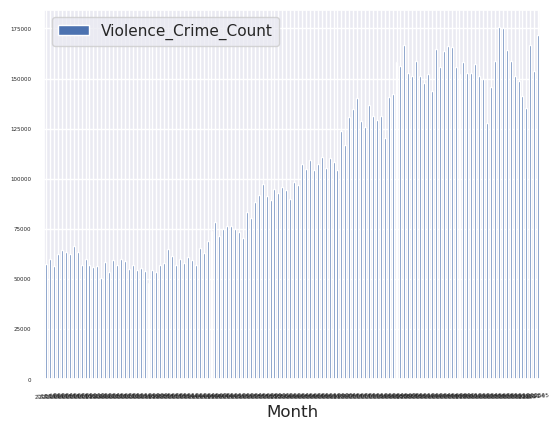

In [23]:
#Using a Bar graph to plot the number of violence

pdf.plot(x="Month", y="Violence_Crime_Count", kind="bar", rot=5, fontsize=4)
plt.show()

The bars indicate the number of violence over the months.The graph shows that as the years increases so also 
the number of violence. However, there was a drop in the number of violence in the latter months. 

### Claim 1 Result: 
Based on the methods and visualisations above, it can be interpreted that Violent crime appears stable at the start in 2010, then increases from 2015. Therefore, Violent Crime is increasing.

# 5) Selection, application, and reasoning behind use of statistical analysis and multiple evaluation measures   _markdown_, _code_,  _markdown_, 20 Marks

## Solution

Out of the 44 towns, villages, and cities in the West Midlands, Birmingham is the most deadly large city and one of the top 10 most dangerous overall. In Birmingham, there were 137 crimes committed per 1,000 persons in 2021. This is 17% higher than other UK states general crime rate of 118 per 1,000 people, which makes for a poor comparison. Birmingham is the second-most hazardous large city in all of England, Wales, and Northern Ireland, and it ranks 238th out of all towns, cities, and villages in terms of danger[4]. This shows that drugs (2.1 to 3.0) and possession of weapons (1.0 to 2.4) is on the increase from 2018 to 2021. To find if there are more firearm incidents in Birmingham than other Uk states, the dataset is filtered to obtain the total number of firearm crime s per location and it is joined with the LSOA dataset by geography and LSOA name, after the number of firearms is divided by number of residents per location. This shows the number of firearms incidents in the UK.

In [24]:
#Filtering the Crime dataset to display the firearms crime type

crime_filter = df.select("LSOAcode","LSOAname")\
.filter((df.Crimetype == "Possession of weapons") & (df.Lastoutcome == "Offender sent to prison"))

In [25]:
#Display the LSOA dataset to show the geography, geography code, residents and density

LSOA_filter = df2.select("geography","geographycode","residents","density")

In [26]:
#It is noticed the geography column has 5 characters after the states including the states which needs to be 
#removed in order to enhance smooth dataset joining

LSOA_states = LSOA_filter.withColumn("states", expr("substring(geography, 1, length(geography)-5)"))

In [27]:
LSOA_states.show(3)

+---------------+-------------+---------+-------+----------+
|      geography|geographycode|residents|density|    states|
+---------------+-------------+---------+-------+----------+
|Darlington 001B|    E01012334|     2466|    0.4|Darlington|
|Darlington 001C|    E01012335|     1383|   12.1|Darlington|
|Darlington 001D|    E01012366|     2008|    0.3|Darlington|
+---------------+-------------+---------+-------+----------+
only showing top 3 rows



In [28]:
#The crime dataset is joined with the LSOA dataset where the states are similar

firearms_incidents = crime_filter.join(LSOA_states).where(crime_filter.LSOAcode == LSOA_states.geographycode)

In [29]:
firearms_incidents.show(3)

+---------+------------+------------+-------------+---------+-------+-------+
| LSOAcode|    LSOAname|   geography|geographycode|residents|density| states|
+---------+------------+------------+-------------+---------+-------+-------+
|E01014636|Bristol 004D|Bristol 004D|    E01014636|     1496|   55.7|Bristol|
|E01014629|Bristol 018D|Bristol 018D|    E01014629|     1477|   56.7|Bristol|
|E01014485|Bristol 023A|Bristol 023A|    E01014485|     1817|   66.1|Bristol|
+---------+------------+------------+-------------+---------+-------+-------+
only showing top 3 rows



In [30]:
#Using the states column, the number of firearms crime is counted per state

firearms_count =firearms_incidents.groupBy('states').count().distinct().orderBy('states', ascending=True)

In [31]:
#Renaming the states and the count to reflect the right usuage

firearms_count = firearms_count.withColumnRenamed('states', 'uk_states').withColumnRenamed('count', 'No_of_firearms')

In [32]:
firearms_count.show()

+--------------------+--------------+
|           uk_states|No_of_firearms|
+--------------------+--------------+
|                Adur|             2|
|           Allerdale|            21|
|        Amber Valley|            27|
|                Arun|            14|
|            Ashfield|            21|
|             Ashford|            15|
|      Aylesbury Vale|            27|
|             Babergh|             3|
|Barking and Dagenham|            49|
|              Barnet|            43|
|            Barnsley|            64|
|   Barrow-in-Furness|            19|
|            Basildon|            36|
|Basingstoke and D...|            14|
|           Bassetlaw|            26|
|Bath and North Ea...|             6|
|             Bedford|            50|
|              Bexley|            16|
|          Birmingham|           235|
|               Blaby|             1|
+--------------------+--------------+
only showing top 20 rows



In [33]:
#Displaying unique vales for states, residents and density

firearms_sum =  firearms_incidents.groupBy('states').sum('residents','density').distinct()


In [34]:
#Removing duplicate values from the datafrme and ordering with respect to states in an ascending order

firearms_sum1 = firearms_sum.dropDuplicates(["states","sum(residents)","sum(density)"]).orderBy('states', ascending=True)

In [35]:
firearms_sum1.show()

+--------------------+--------------+------------------+
|              states|sum(residents)|      sum(density)|
+--------------------+--------------+------------------+
|                Adur|          2929|              94.2|
|           Allerdale|         33900|             641.3|
|        Amber Valley|         44134|             619.4|
|                Arun|         23490|             673.3|
|            Ashfield|         36793| 725.4000000000001|
|             Ashford|         24055| 575.8000000000001|
|      Aylesbury Vale|         37710|            1034.0|
|             Babergh|          4531| 91.69999999999999|
|Barking and Dagenham|         89838|3589.0000000000005|
|              Barnet|         77183| 2689.600000000001|
|            Barnsley|        103317|2310.8000000000006|
|   Barrow-in-Furness|         27081| 861.5999999999999|
|            Basildon|         61003|1479.9999999999993|
|Basingstoke and D...|         20980|             495.7|
|           Bassetlaw|         

In [36]:
#Joining the firearms_sum1 dataframe which contains the  states, residents and density with the 
#firearms_count which contain the states and number of firearms per states

firearms = firearms_sum1.join(firearms_count,firearms_sum1.states ==  firearms_count.uk_states,"left")

In [37]:
# It is noticed that there are duplicate states which is where one is dropped

firearms = firearms.drop('uk_states')

In [38]:
firearms.show()

+--------------------+--------------+------------------+--------------+
|              states|sum(residents)|      sum(density)|No_of_firearms|
+--------------------+--------------+------------------+--------------+
|           Worcester|         50989|            1381.6|            37|
|           Charnwood|         21636| 538.0999999999999|            12|
|      North Kesteven|          6295|19.900000000000002|             4|
|                Arun|         23490|             673.3|            14|
|       Epping Forest|         14100|275.70000000000005|             9|
|             Waveney|         24996|             443.0|            14|
|              Stroud|          7657|              63.2|             4|
|              Maldon|          5439|23.599999999999998|             3|
|          New Forest|          8106|             163.7|             5|
|           Sedgemoor|         21667|             336.8|            12|
|           Guildford|          6829|             286.9|        

In [39]:
#Since the residents per states and number of firearms per states, the number of firearms per head is 
#calculated and it is parsed to new column

firearms_per_head = firearms.withColumn('per_head',F.col('No_of_firearms')/F.col('sum(residents)'))

In [40]:
firearms_per_head.show()

+--------------------+--------------+------------------+--------------+--------------------+
|              states|sum(residents)|      sum(density)|No_of_firearms|            per_head|
+--------------------+--------------+------------------+--------------+--------------------+
|           Worcester|         50989|            1381.6|            37|7.256467081135147E-4|
|           Charnwood|         21636| 538.0999999999999|            12|5.546311702717693E-4|
|      North Kesteven|          6295|19.900000000000002|             4|6.354249404289118E-4|
|                Arun|         23490|             673.3|            14|5.959982971477225E-4|
|       Epping Forest|         14100|275.70000000000005|             9|6.382978723404255E-4|
|             Waveney|         24996|             443.0|            14|5.600896143382942E-4|
|              Stroud|          7657|              63.2|             4|5.223978059292151E-4|
|              Maldon|          5439|23.599999999999998|             3

In [41]:
#To show the number of firearms per head in Birmingham, the states column is filtered

firearms_per_head_in_Birmingham = firearms_per_head.select("per_head").filter(firearms_per_head.states == 'Birmingham')

In [42]:
firearms_per_head_in_Birmingham.show()

+--------------------+
|            per_head|
+--------------------+
|5.854246695464579E-4|
+--------------------+



In [43]:
#Displaying the top 25 firearms incidents per head for the various UK states

firearms_per_head.groupBy("states").max("per_head").show(25)

+--------------------+--------------------+
|              states|       max(per_head)|
+--------------------+--------------------+
|           Worcester|7.256467081135147E-4|
|           Charnwood|5.546311702717693E-4|
|      North Kesteven|6.354249404289118E-4|
|                Arun|5.959982971477225E-4|
|       Epping Forest|6.382978723404255E-4|
|             Waveney|5.600896143382942E-4|
|              Stroud|5.223978059292151E-4|
|              Maldon|5.515719801434088E-4|
|          New Forest| 6.16827041697508E-4|
|           Sedgemoor|5.538376332671805E-4|
|           Guildford|5.857372968223752E-4|
|            Worthing|5.616505036132849E-4|
|             Fareham|6.629415664362155E-4|
|              Bolton|6.162763583064059E-4|
|Central Bedfordshire|5.832965090587716E-4|
|      North Tyneside|6.356571900773913E-4|
|        Surrey Heath|6.090133982947625E-4|
|      Wellingborough|6.161971830985916E-4|
|              Slough| 5.54793120565305E-4|
|          Spelthorne|6.20539869

In [44]:
#Creating a model to predict the trend on number of firearms per head, The firearms_per_head is splited 
#into training and testing set

(trainDF, testDF) = firearms_per_head.randomSplit([.8, .2], seed=42)
print(f"""There are {trainDF.count()} rows in the training set, and {testDF.count()} in the test set""")

There are 270 rows in the training set, and 67 in the test set


In [45]:
#Vectorise the features into one column

vecAssembler = VectorAssembler(inputCols=['per_head'], outputCol="features")
vecTrainDF = vecAssembler.transform(trainDF)
vecTrainDF.select('states', 'No_of_firearms', 'sum(residents)', 'per_head').show(4)

+--------------+--------------+--------------+--------------------+
|        states|No_of_firearms|sum(residents)|            per_head|
+--------------+--------------+--------------+--------------------+
|     Worcester|            37|         50989|7.256467081135147E-4|
|North Kesteven|             4|          6295|6.354249404289118E-4|
|          Arun|            14|         23490|5.959982971477225E-4|
|       Waveney|            14|         24996|5.600896143382942E-4|
+--------------+--------------+--------------+--------------------+
only showing top 4 rows



In [53]:
# Train the Linear Regression Model

lr = LinearRegression(featuresCol="features", labelCol="No_of_firearms")
lrModel = lr.fit(vecTrainDF)
pipeline = Pipeline(stages=[vecAssembler, lr])
pipelineModel = pipeline.fit(trainDF)

In [54]:
# Make predictions from the test data

predDF = pipelineModel.transform(testDF)
predDF.select('states', 'No_of_firearms', 'sum(residents)', 'per_head', "prediction").show(4)

+-------------+--------------+--------------+--------------------+------------------+
|       states|No_of_firearms|sum(residents)|            per_head|        prediction|
+-------------+--------------+--------------+--------------------+------------------+
|    Charnwood|            12|         21636|5.546311702717693E-4|33.104958574086666|
|Epping Forest|             9|         14100|6.382978723404255E-4|26.379576881303656|
|    Sedgemoor|            12|         21667|5.538376332671805E-4| 33.16874547032202|
|       Slough|            38|         68494| 5.54793120565305E-4| 33.09194052135654|
+-------------+--------------+--------------+--------------------+------------------+
only showing top 4 rows



In [55]:
# Evaluate the model
regressionEvaluator = RegressionEvaluator(
 predictionCol="prediction",
 labelCol="per_head",
 metricName="rmse")
rmse = regressionEvaluator.evaluate(predDF)
print(f"RMSE is {rmse:.1f}")

RMSE is 31.0


In [56]:
#Alternatively, selective features can be parsed into the model
def runlr(trainDF, testDF, feature_cols):
    vecAssembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    vecTrainDF = vecAssembler.transform(trainDF)
    lr = LinearRegression(featuresCol="features", labelCol="per_head")
    lrModel = lr.fit(vecTrainDF)
    pipeline = Pipeline(stages=[vecAssembler, lr])
    pipelineModel = pipeline.fit(trainDF)
    return pipelineModel.transform(testDF)

In [50]:
predDF = runlr(trainDF, testDF, ['No_of_firearms', 'sum(residents)', 'per_head'])

In [51]:
#RMSE is higher
rmse = regressionEvaluator.evaluate(predDF)
print(f"RMSE is {rmse:.3f}")

RMSE is 53.354


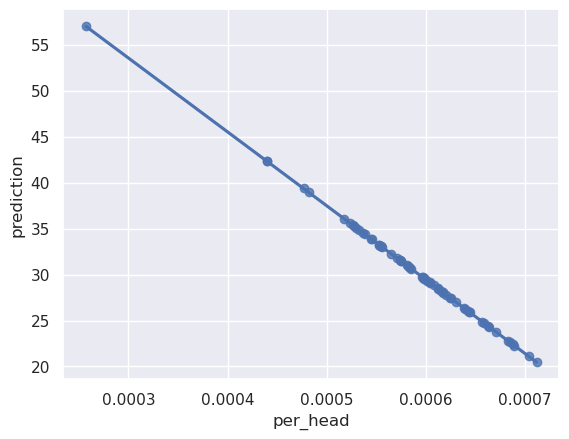

In [57]:
# Visualize the model
# use seaborn to get trendline
pandf = predDF.select( "per_head", "prediction").toPandas()

ax =sns.regplot(x= 'per_head', y='prediction', data = pandf)
plt.show()

### Claim 2 Result: 
No, there are not more firearms per head incidents in Birmingham than any other UK states, Birmingham has one of the highest firearms incidents incident per head values of 5.854246695464579E-4.The state with the highest firearm incident is Worcester with an firearm incident per head value of 7.256467081135147E-4.

# To determine whether firearms incidents are associated with drugs offences

In [58]:
#Filter the crime dataset when the crimetype is drugs and parsed to the drug_filter dataframe

drug_filter = df.select("LSOAcode","LSOAname")\
.filter((df.Crimetype == "Drugs"))

In [59]:
#The drug_filter dataframe is joined with the LSOA dataframe

drug_incidents = drug_filter.join(LSOA_states).where(drug_filter.LSOAcode == LSOA_states.geographycode)

In [60]:
#The number of drug offenses is counted per states

drug_count =drug_incidents.groupBy('states').count().distinct().orderBy('states', ascending=True)

In [61]:
#Renaming the various columns

drug_count = drug_count.withColumnRenamed('states', 'drug_uk_states').withColumnRenamed('count', 'No_of_drugs')

In [62]:
drug_count.show(3)

+--------------+-----------+
|drug_uk_states|No_of_drugs|
+--------------+-----------+
|          Adur|       1301|
|     Allerdale|       2494|
|  Amber Valley|       2305|
+--------------+-----------+
only showing top 3 rows



In [63]:
#The dataframe containing the number drug offenses per state is joined with the number of firearms per state

drug_correllation = drug_count.join(firearms_count,drug_count.drug_uk_states == firearms_count.uk_states,"left")

In [64]:
drug_correllation.show()

+--------------------+-----------+--------------------+--------------+
|      drug_uk_states|No_of_drugs|           uk_states|No_of_firearms|
+--------------------+-----------+--------------------+--------------+
|           Worcester|       3384|           Worcester|            37|
|           Charnwood|       2605|           Charnwood|            12|
|      North Kesteven|       1037|      North Kesteven|             4|
|                Arun|       3444|                Arun|            14|
|       Epping Forest|       2700|       Epping Forest|             9|
|             Waveney|       2549|             Waveney|            14|
|              Stroud|       1686|              Stroud|             4|
|              Maldon|        769|              Maldon|             3|
|          New Forest|       2524|          New Forest|             5|
|           Sedgemoor|       2202|           Sedgemoor|            12|
|           Guildford|       4180|           Guildford|             4|
|     

In [65]:
#Null values are removed from resulting dataframe

drug_correllation1 = drug_correllation.na.drop(how="any")

In [66]:
drug_correllation1.columns

['drug_uk_states', 'No_of_drugs', 'uk_states', 'No_of_firearms']

In [67]:
#Since the states are not required to show the relationship between firearms and drug offenses, 
#both columns are dropped

drug_correllation1 = drug_correllation1.drop('uk_states')

In [68]:
drug_correllation1 = drug_correllation1.drop('drug_uk_states')

In [69]:
#Using Pearson's correlation to calculate the correlation coefficient 

drug_correllation1.corr("No_of_drugs", "No_of_firearms")

0.8411969373107644

The values above shows a positive relationship the firearms and drug offenses columns. It also shows a strong correlation.

In [70]:
#To evaluate the relationship using model fitting

(trainDF, testDF) = drug_correllation1.randomSplit([.8, .2], seed=42)
print(f"""There are {trainDF.count()} rows in the training set, and {testDF.count()} in the test set""")

There are 270 rows in the training set, and 67 in the test set


In [71]:
#Vectorise the selected column

vecAssembler = VectorAssembler(inputCols=['No_of_drugs','No_of_firearms'], outputCol="features")
vecTrainDF = vecAssembler.transform(drug_correllation1)
vecTrainDF1 = vecTrainDF.select('features', 'No_of_drugs','No_of_firearms').show(4)

+-------------+-----------+--------------+
|     features|No_of_drugs|No_of_firearms|
+-------------+-----------+--------------+
|[3384.0,37.0]|       3384|            37|
|[2605.0,12.0]|       2605|            12|
| [1037.0,4.0]|       1037|             4|
|[3444.0,14.0]|       3444|            14|
+-------------+-----------+--------------+
only showing top 4 rows



In [74]:
#The result of vectorisation is parsed into the linear regression model

lr = LinearRegression(featuresCol = 'features', labelCol='No_of_drugs', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(vecTrainDF)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [0.9999340847136184,0.0012418237447847488]
Intercept: 0.2701653666691672


The coefficient shows a positive and a strong correlation between the drug offenses and firearms columns.

In [75]:
#Displaying the RMSE and R2
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 0.301206
r2: 1.000000


RMSE and R-squared shows how well the linear regression model fits a dataset. While R-Square indicates how well 
the predictor variables (number of drugs) can explain the variation in the response variable, 
RMSE indicates how well a regression model can predict the value of a response variable in absolute terms[5].

In [76]:
#Describing the values from both columns

trainDF.describe().show()

+-------+-----------------+-----------------+
|summary|      No_of_drugs|   No_of_firearms|
+-------+-----------------+-----------------+
|  count|              270|              270|
|   mean|4549.288888888889|29.37037037037037|
| stddev|4698.469971423335|33.27216610076714|
|    min|              331|                1|
|    max|            28471|              235|
+-------+-----------------+-----------------+



The dataframe summary shows that the total count for each column is 270, the mean for number of drugs is 4549.3 while for number of firearms is 29.37. Also the standard deviation for number of drugs is 4698.5 and for number of firearms is 33.27. The min count value for number of drugs is 331 and max is 28471 while the min count value for the number of firearms is 1 and max is 235

In [78]:
#Using the number of drugs as a predictor to get the R2 on the test data

lr_predictions = lr_model.transform(vecTrainDF)
lr_predictions.select("prediction","No_of_drugs","No_of_firearms","features").show(5)

from pyspark.ml.evaluation import RegressionEvaluator

lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="No_of_drugs",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+------------------+-----------+--------------+-------------+
|        prediction|No_of_drugs|No_of_firearms|     features|
+------------------+-----------+--------------+-------------+
| 3384.093055516111|       3384|            37|[3384.0,37.0]|
|2605.1133579305824|       2605|            12|[2605.0,12.0]|
|1037.2067785096706|       1037|             4| [1037.0,4.0]|
|3444.0605386527977|       3444|            14|[3444.0,14.0]|
|2700.1033705071422|       2700|             9| [2700.0,9.0]|
+------------------+-----------+--------------+-------------+
only showing top 5 rows

R Squared (R2) on test data = 1


In [79]:
#using seaborn to get trendline

pandf = lr_predictions.select( "prediction", "No_of_firearms").toPandas()

ax =sns.regplot(x= 'No_of_firearms', y='prediction', data = pandf)

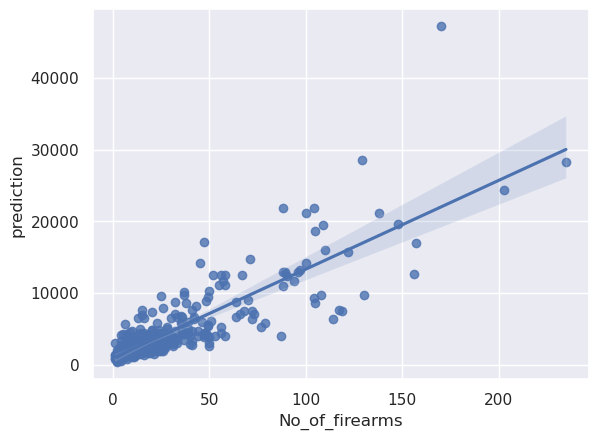

In [80]:
plt.show()

The plot shows a positive relationship between number of drugs (drug offense) and number of firearms (firearms incident). There also exist a strong correlation. The values are clustered around the lower digits on the y-axis.

### Claim 3 Result:
Yes, Crimes involving firearms are closely associated with drugs offenses, as show by the plot above, there exist a strong association between the crime types.

# 6) Detailed Analysis and consideration of the appropriateness of the solution for the initial problem  _markdown_, 10 Marks

## Solution

### Time series
A particular method of examining a set of data points gathered over a period of time is called a "time series analysis". Instead of just capturing the data points intermittently or arbitrarily, time series analysis records the data points at regular intervals over a predetermined length of time[6].

Advantages
- Time Series Analysis Aids in Pattern Recognition by plotting the data on a line chart
- Time Series Analysis Offers the Possibility of Data Cleaning, gaps within the time series are identified, where they can be handled by imputing the missing values. Also, outliers can be identified.
- The Future Can Be Predicted Using Time Series Forecasting where useful insights can be extracted from past behavior and looking at how they fit into the future.
- It can be helpful in evaluating the performances of predetermined targets

Disadvantages
- Time series does not take into consideration random factors when making predictions
- The shape of the data is hardly known during data processing

Limitation
- It is hard to make sense of the data if there is no domain knowledge
- Temporal effects are so weak that it makes more sense to just the non-temporal ones

### Statistical analysis
It is the procedure of gathering and examining data to spot trends and patterns, eliminate bias, and guide decision-making. It is a feature of business intelligence that entails the gathering and examination of commercial data as well as the reporting of trends[7].

Advantages
- Trim operating expenses where companies can identify spending trends and conduct more precise cost and data analyses with the use of statistical analysis.
- Conduct a market analysis where businesses can do precise market analyses with the aid of statistical analysis. The data can reveal where sales are most common, where they are most valuable, and what marketing is associated with those transactions. It enables increased effectiveness in all facets of sales and marketing.
- Improve office productivity where statistical analysis can increase productivity at work. For instance, we are aware that giving staff the proper tools might help them produce their best work. Employers can examine the effectiveness of each instrument and concentrate on those that best support performance by using statistical analysis.
- Make better decisions where the foundation of business intelligence and well-informed decision-making is statistical analysis. A/B testing and descriptive statistics give a clear picture of which options are popular with customers or leads. This is crucial for firms who don't have a continuous stream of customers as well as for those looking to expand their product offerings or client bases.

Disadvantages
- Sampling Error where the quality of a statistical test depends on the data it uses. Researchers' statistical analyses will be inaccurate if they obtain data in an unreliable or biased manner.
- Correlation versus Causation where the propensity for statistical analysis to draw hasty conclusions regarding causal links is another issue.
- Construct validity where statistical analysis is a tool for analysing aggregated data to make inferences, but the analysis will be ineffective if researchers aren't measuring the proper item.
- Simplified Solutions where A final problem with statistical analysis is its tendency to produce excessively simple answers to complex questions.

Limitations
- Qualitative factors like IQ and health are disregarded.
- It doesn't deal with individual things.
- The full tale of the phenomenon is not presented.
- It could be mishandled
- Laws are not exactly accurate
- Results are only usually accurate.

### Model Fitting
Model fitting is a metric used to assess how well a machine learning model generalises data that is comparable to the data used for training[8].

Advantages
- It offers parameter statistical tests, allowing for statistically sound assessments of parameter variations between groups or situations.
- Simple implementation where the model can be implemented easily
- Performance on linearly separable datasets where the model fits linearly separable datasets almost perfectly and it is used to find the nature of the relationship between variables.

Disadvantages
- Prone to underfitting where the model fails to capture the data properly.
- Sensitive to outliers which are anomalies that deviate from the ither data points of the distribution.

Limitations
- It does not calculate multiple nonlinear regression
- Model fitting does not have any syntax to allow for summations or loops




# 7) Evaluation and Conclusion  _markdown_, 10 Marks

Based on the analysis on each of the claims, violent crime/violence and sexual crime is on the increase starting from 2015 and peaked in 2021, there is strong association between the count of violent crime/violence and sexual crimes and the months. In the seasonal plot, there is a consistent period each year where the number of violent crime/violence and sexual crimes is high and low, so measures can be put in place to curb crime during its peak periods. The number of firearms incidents per head incidents analysis for Birmingham is 5.854246695464579E-4 which is relatively high. So no, Birmingham does not have more firearms per head incidents than anywhere else in the UK. Based on the plot, there appear to be an inverse relationship between the predictions and the firearms incidents per head. Firearms prevention measures should be put place in states with firearms incidents per head of over 4.5E-4 such as regular patrols, video surveillance etc. There exist a strong association between firearms and drugs offences which could infers that the factors that affect one could impact the other one. It could be as a result of drug offenders possessing weapons to enforce their business or criminals using guns to steal to buy drugs. This strong correlation makes it easy in curbing these crime types. Measure such as sensitsation, gun exchange programs could be effective in reducing the numbers.



# 8) References and Citation _markdown_, 10 Marks

References are essential at level 7. in this section you should give references for the papers/books you have cited in this assignment. Try to avoid using web pages as these are considered _weak references_ as they are often not reviewed.

[1] G. Hales, C. Lewis and D. Silverstone (2006, Dec). Gun crime: the market in and use of illegal firearms [Online]. Available: https://pure.port.ac.uk/ws/portalfiles/portal/1926252/home_office_gun_crime_the_market_in_and_use_of_illegal_firearms.pdf

[2] T. McSweeney. P. Turnbull and M. Hough (2008, July).Tackling Drug Markets and Distribution Networks in the UK [Online]. Available: https://www.ukdpc.org.uk/wp-content/uploads/Policy%20report%20-%20Tackling%20drug%20markets%20and%20distribution%20networks%20in%20the%20UK.pdf


[3] A. Kirlic and M. Hadzic (2017, Jan). Big data and time series: A literature review paper [Online]. Available: https://www.researchgate.net/publication/324491094_Big_data_and_time_series_A_literature_review_paper

[4] CrimeRate (2022). Crime and safety in Birmingham [Online]. Available: https://crimerate.co.uk/west-midlands/birmingham

[5] A. Chugh (2020, Dec 8). MAE, MSE, RMSE, Coefficient of Determination, Adjusted R Squared — Which Metric is Better? [Online]. Available: https://medium.com/analytics-vidhya/mae-mse-rmse-coefficient-of-determination-adjusted-r-squared-which-metric-is-better-cd0326a5697e#:~:text=Both%20RMSE%20and%20R%2D%20Squared,variation%20in%20the%20response%20variable.

[6] J. Emery (2021, Mar 04). 3 Advantages to Time series analysis and forecasting [Online]. Available: https://www.phdata.io/blog/3-advantages-to-time-series-analysis-and-forecasting/

[7] J.Bender (2022, Aug 12). What is Statistical Analysis? [Online]. Available: https://www.businessnewsdaily.com/6000-statistical-analysis.html

[8] N. Singh (No data). Advantages and disadvantages of Linear Regression [Online]. Available: https://iq.opengenus.org/advantages-and-disadvantages-of-linear-regression/